# Tutorial 3 - Variational classifier

In Tutorial 3 we show how to use Penny Lane to implement variational quantum classifiers - quantum circuits that can be trained from labelled data how to classify new data samples. The architecture is inspired by Farhi & Neven (2018 arXiv:1802.06002) as well as Schuld, Bocharov, Wiebe and Svore (2018 arXiv:1804.00633). 

We will first show that the variational quantum classifier can reproduce the parity function

$$ f: x \in \{0,1\}^{\otimes n} \rightarrow y = \begin{cases} 1 \text{  if uneven number of ones in } x \\ 0 \text{ else} \end{cases}.$$

This optimization example is supposed to demonstrate how to encode binary inputs into the initial state of the variational circuit, which is simply a computational basis state.

We then show how to encode real vectors as amplitude vectors (*amplitude encoding*) and train the model to recognise the first two classes of flowers in the Iris dataset.

## 1. Fitting the parity function 

To demonstrate a clean handling of numpy and Penny Lane's numpy side by side, we import them both this time.

### Imports

In [24]:
import numpy as np
import pennylane as qml
from pennylane import numpy as onp
from pennylane.optimize import NesterovMomentumOptimizer

### Quantum and classical nodes

We create a quantum device with four "wires" or qubits.

In [2]:
dev = qml.device('default.qubit', wires=4)

Variational classifiers usually define a "layer" or "block", which is an elementary circuit architecture that gets repeated to build the variational circuit.

<IMage>

Our circuit layer consists of an arbitrary rotation on every qubit, as well as CNOTs that entangle each qubit with its neighbour.

<IMage>

In [3]:
def layer(W):

    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=[0])
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=[1])
    qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=[2])
    qml.Rot(W[3, 0], W[3, 1], W[3, 2], wires=[3])

    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[3, 0])

We also need a way to encode data inputs $x$ into the circuit, so that the measured output depends on the inputs. In this first example, the inputs are bitstrings, which we encode into the state of the qubits. The quantum state $|\psi \rangle $ after state preparation is a computational basis state that has 1's where $x$ has 1s, for example

$$ x = 0101 \rightarrow |\psi \rangle = |0101 \rangle . $$

We use the `BasisState` function, which expects `x` to be a list of zeros and ones, i.e. `[0,1,0,1]`.

*Note: Penny Lane wraps the arguemtns of a quantum node, so they cannot be evaluated directly by the user. For example, this will NOT work:*

    for i in range(len(x)):
        if x[i] == 1:
            qml.PauliX([i])


In [4]:
def statepreparation(x):

    qml.BasisState(x, wires=[0, 1, 2, 3])

Now we can elegantly define the quantum node as a state preparation routine, followed by a repitition of the layer structure. Borrowing from machine learning, we call the parameters `weights`.

In [5]:
@qml.qnode(dev)
def circuit(weights, x=None):

    statepreparation(x)

    for W in weights:
        layer(W)

    return qml.expval.PauliZ(0)

Different from previous tutorials, the quantum node takes the data as a keyword argument `x` (with the default value `None`). Keyword arguments of a quantum node are considered as fixed when calculating a gradient, so they are never trained.

If we want to add a "classical" bias parameter, the variational quantum classifer also needs some post-processing. We define the final model by a classical node that uses the first variable, and feeds the remainder into the quantum node. Before this, we reshape the list of remaining variables for easy use in the quantum node.

In [6]:
def variational_classifier(var, x=None):

    weights = var[0]
    bias = var[1]

    return circuit(weights, x=x) + bias

### Cost

The objective or cost in supervised learning is the sum of a loss and a regularizer. We use the standard square-loss that measures the distance between target labels and model predictions. 

In [7]:
def square_loss(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        loss += (l-p)**2
    loss = loss/len(labels)

    return loss

To monitor how many inputs the current classifier predicted correctly, we also define the accuracy given target labels and model predictions. 

In [8]:
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l-p) < 1e-5:
            loss += 1
    loss = loss/len(labels)

    return loss

For learning tasks, the cost depends on the data - here the features and labels considered in the iteration of the optimization routine.

In [9]:
def cost(var, X, Y):

    predictions = [variational_classifier(var, x=x) for x in X]

    return square_loss(Y, predictions) 

### Optimization

Let us load and preprocess some data. 

In [10]:
data = np.loadtxt("data/parity.txt")
X = data[:, :-1]
Y = data[:, -1]
Y = Y*2 - np.ones(len(Y))  # shift label from {0, 1} to {-1, 1}

for i in range(5):
    print('X = {}, Y = {: d}'.format(X[i], int(Y[i])))
print('...')


X = [0. 0. 0. 0.], Y = -1
X = [0. 0. 0. 1.], Y =  1
X = [0. 0. 1. 0.], Y =  1
X = [0. 0. 1. 1.], Y = -1
X = [0. 1. 0. 0.], Y =  1
...


Initialize the variables randomly. The first variable in the list is used as a bias, while the rest is fed into the gates of the variational circuit.

In [11]:
num_qubits = 4
num_layers = 2
var_init = (0.01*np.random.randn(num_layers, num_qubits, 3), 0.0)

var_init

(array([[[ 0.00410209,  0.00975613, -0.00415873],
         [-0.02354687, -0.0220707 ,  0.00279615],
         [ 0.01054597, -0.01010535, -0.00413055],
         [ 0.01449659,  0.01109573,  0.0051608 ]],
 
        [[ 0.00794237,  0.00946688, -0.00905895],
         [ 0.00382248,  0.0002072 ,  0.00104666],
         [-0.01648454,  0.00796432, -0.01139746],
         [-0.00076741,  0.00400161,  0.00868327]]]), 0.0)

Create an optimizer and choose a batch size...

In [12]:
o = NesterovMomentumOptimizer(0.5)
batch_size = 5

...and train the optimizer. We track the accuracy - the share of correctly classified data samples. For this we compute the outputs of the variational classifier and turn them into predictions in $\{-1,1\}$ by taking the sign of the output.

In [13]:
var = var_init
for it in range(0):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, len(X), (batch_size, ))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    var = o.step(lambda v: cost(v, X, Y), var)

    # Compute accuracy
    predictions = [np.sign(variational_classifier(var, x=x)) for x in X]
    acc = accuracy(Y, predictions)

    print("Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(it+1, cost(var, X, Y), acc))

## 2. Iris classification

### Quantum and classical nodes

To encode real-valued vectors into the amplitudes of a quantum state, we use a 2-qubit simulator.

In [14]:
dev = qml.device('default.qubit', wires=2)

State preparation is not as simple as when we represent a bitstring with a basis state. Every input x has to be translated into a set of angles (called "betas" here) which can get fed into a small circuit for state preparation. The circuit is coded according to the scheme in Möttönen, Vartiainen, Bergholm, and Salomaa 2004 (arXiv:0407010v1), or as presented in Schuld & Petruccione 2018 (Springer). We had to also decompose controlled y-rotations into more basic circuits following Nielsen & Chuang 2010 (Cambridge). *Note that we have a slightly different definition of the R_y gate here*.

In [27]:
def get_beta(x):

    beta0 = 2*np.arcsin(x[1] / np.sqrt(x[0]**2 + x[1]**2))
    beta1 = 2*np.arcsin(x[3] / np.sqrt(x[2]**2 + x[3]**2))
    beta2 = 2*np.arcsin(np.sqrt(x[2]**2 + x[3]**2) / np.sqrt(x[0]**2 + x[1]**2 + x[2]**2 + x[3]**2))

    return beta0, beta1, beta2


def statepreparation(betas):

    qml.RY(betas[0], [0])

    qml.CNOT([0, 1])
    qml.RY(betas[1], [1])
    qml.CNOT([0, 1])
    qml.RY(betas[2], [1])

    qml.PauliX([0])
    qml.CNOT([0, 1])
    qml.RY(betas[3], [1])
    qml.CNOT([0, 1])
    qml.RY(betas[4], [1])
    qml.PauliX([0])

Let's test if this routine actually works. Given

In [29]:
x = np.array([-0.53896774, 0.79503606, 0.27826503, 0.])
betas = get_betas(x)

@qml.qnode(dev)
def test(betas=None):

    statepreparation(betas)

    return qml.expval.PauliZ(0)

test(betas=betas)

print("x               : ", x)
print("betas           : ", betas)
print("amplitude vector: ", np.real(dev._state))

x               :  [-0.53896774  0.79503606  0.27826503  0.        ]
betas           :  [0.5639746511208602, -0.0, 0.0, -0.9750460406385351, 0.9750460406385351]
amplitude vector:  [ 5.38967743e-01  7.95036065e-01  2.78265032e-01 -1.38777878e-17]


Note that the qubit backend allows a shortcut to statepreparation with 
...

However, most devices will not support an arbitrary state preparation routine.

Since we are working with only 2 qubits now, we need to update the layer function as well.

In [17]:
def layer(W):

    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=[0])
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=[1])

    qml.CNOT(wires=[0, 1])

The variational classifier model and its cost remain essentially the same, but we have to reload them with the new state preparation and layer functions.

In [18]:
@qml.qnode(dev)
def circuit(weights, betas=None):

    statepreparation(betas)

    for W in weights:
        layer(W)

    return qml.expval.PauliZ(0)


def variational_classifier(var, betas=None):

    weights = var[0]
    bias = var[1]

    return circuit(weights, betas=betas) + bias

def cost(weights, features, labels):

    predictions = [variational_classifier(weights, betas=f) for f in features]

    return square_loss(labels, predictions)

### Data

We then load the Iris data set. There is a bit of preprocessing to do in order to encode the inputs into the amplitudes of a quantum state. In the last preprocessing step, we translate the inputs x to rotation angles "beta". 

In [19]:
data = np.loadtxt("data/iris_scaled.txt")
X = data[:, 0:2]
print("First X sample (original)  :", X[0])

# padd the vectors to size 2^2 with constant values
padding = 0.3*np.ones((len(X), 1))
X_pad = np.c_[np.c_[X, padding],np.zeros((len(X), 1)) ] 
print("First X sample (padded)    :", X_pad[0])

# normalize each input
normalization = np.sqrt(np.sum(X_pad** 2, -1))
X_norm = (X_pad.T / normalization).T  
print("First X sample (normalized):", X_norm[0])

# angles for state preparation are new features
features = np.array([get_betas(x) for x in X_norm])  
print("First features sample      :", features[0])

Y= data[:, -1]
Y = Y*2 - np.ones(len(Y))  # shift from {0, 1} to {-1, 1}

First X sample (original)  : [-0.5810659   0.85713543]
First X sample (padded)    : [-0.5810659   0.85713543  0.3         0.        ]
First X sample (normalized): [-0.53896774  0.79503606  0.27826503  0.        ]
First features sample      : [ 0.56397466 -0.          0.         -0.97504604  0.97504604]


These angles are our new features, which is why we have renamed X to "features" above. Let's plot the stages of preprocessing. Play around with the dimensions (dim1, dim2). Some of them still separate the classes well, while others are less informative.

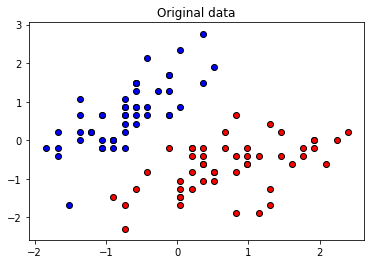

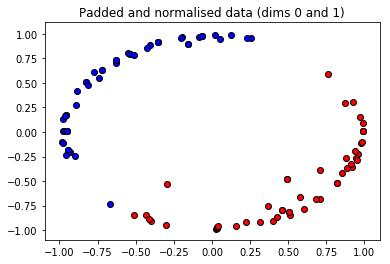

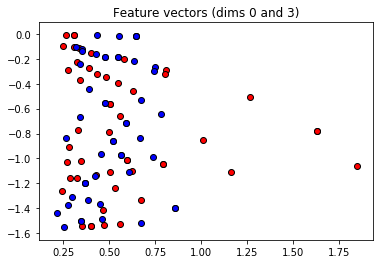

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.scatter(X[:,0][Y== 1], X[:,1][Y== 1], c='r', marker='o', edgecolors='k')
plt.scatter(X[:,0][Y==-1], X[:,1][Y==-1], c='b', marker='o', edgecolors='k')
plt.title("Original data")
plt.show()

plt.figure()
dim1 = 0
dim2 = 1
plt.scatter(X_norm[:,dim1][Y== 1], X_norm[:,dim2][Y== 1], c='r', marker='o', edgecolors='k')
plt.scatter(X_norm[:,dim1][Y==-1], X_norm[:,dim2][Y==-1], c='b', marker='o', edgecolors='k')
plt.title("Padded and normalised data (dims {} and {})".format(dim1, dim2))
plt.show()

plt.figure()
dim1 = 0
dim2 = 3
plt.scatter(features[:,dim1][Y== 1], features[:,dim2][Y== 1], c='r', marker='o', edgecolors='k')
plt.scatter(features[:,dim1][Y==-1], features[:,dim2][Y==-1], c='b', marker='o', edgecolors='k')
plt.title("Feature vectors (dims {} and {})".format(dim1, dim2))
plt.show()

This time we want to generalize from the data samples. To monitor the generalization performance, the data is split into training and validation set.

In [21]:
num_data = len(Y)
num_train = int(0.75*num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[: num_train]]
Y_train = Y[index[: num_train]]
feats_val = features[index[num_train: ]]
Y_val = Y[index[num_train: ]]

# We need these later for plotting
X_train = X[index[: num_train]]
X_val   = X[index[num_train :]]

### Optimization

Initialize the variables.

In [22]:
num_qubits = 2
num_layers = 6
var_init = (0.01*np.random.randn(num_layers, num_qubits, 3), 0.0)

Again we optimize the cost. This may take a little patience.

In [23]:
o = NesterovMomentumOptimizer(0.01)
batch_size = 5

# train the variational classifier
var = var_init
for it in range(20):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size, ))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    var = o.step(lambda v: cost(v, feats_train_batch, Y_train_batch), var)

    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(var, betas=f)) for f in feats_train]
    predictions_val = [np.sign(variational_classifier(var, betas=f)) for f in feats_val]

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    print("Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
          "".format(it+1, cost(var, features, Y), acc_train, acc_val))

Iter:     1 | Cost: 1.7175754 | Acc train: 0.4666667 | Acc validation: 0.4800000 
Iter:     2 | Cost: 1.6435166 | Acc train: 0.4666667 | Acc validation: 0.4800000 
Iter:     3 | Cost: 1.5514432 | Acc train: 0.4666667 | Acc validation: 0.4800000 
Iter:     4 | Cost: 1.4264893 | Acc train: 0.4666667 | Acc validation: 0.4400000 
Iter:     5 | Cost: 1.2955609 | Acc train: 0.4533333 | Acc validation: 0.4000000 
Iter:     6 | Cost: 1.1804405 | Acc train: 0.4666667 | Acc validation: 0.3600000 
Iter:     7 | Cost: 1.1453838 | Acc train: 0.5333333 | Acc validation: 0.4400000 


KeyboardInterrupt: 

We can plot the continuous output of the variational classifier for the first two dimensions of the Iris data set.

In [ ]:
plt.figure()
cm = plt.cm.RdBu

# make data for decision regions
xx, yy = np.meshgrid(np.linspace(-3.1, 3.1, 20), np.linspace(-3.1, 3.1, 20))


X_grid = [np.array([x, -y]) for x, y in zip(xx.flatten(), yy.flatten())] #TODO: why minus?

# preprocessing for grid points
padding = 0.3*np.ones((len(X_grid), 2))
X_grid = np.c_[X_grid, padding] # padd the vectors to size 2^2 with constant values
normalization = np.sqrt(np.sum(X_grid ** 2, -1))
X_grid = (X_grid.T / normalization).T  # normalize each input
features_grid = np.array([get_betas(x) for x in X_grid])  # angles for state preparation are new features
predictions_grid = [variational_classifier(var, betas=f) for f in features_grid]
Z = np.reshape(predictions_grid, xx.shape)

# plot decision regions
cnt = plt.contourf(xx, yy, Z, levels=np.arange(-1, 1.1, 0.1), cmap=cm, alpha=.8, extend='both')
plt.colorbar(cnt, ticks=[-1, 0, 1])

# plot data
plt.scatter(X_train[:,0][Y_train==1], X_train[:,1][Y_train==1], c='b', marker='o', edgecolors='k', label="class 1 train")
plt.scatter(X_val[:,0][Y_val==1], X_val[:,1][Y_val==1], c='b', marker='^', edgecolors='k', label="class 1 validation")
plt.scatter(X_train[:,0][Y_train==-1], X_train[:,1][Y_train==-1], c='r', marker='o', edgecolors='k', label="class -1 train")
plt.scatter(X_val[:,0][Y_val==-1], X_val[:,1][Y_val==-1], c='r', marker='^', edgecolors='k', label="class -1 validation")

plt.legend()
plt.show()